<a href="https://colab.research.google.com/github/khanma1962/Fire-Classification-and-Detection/blob/main/class_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Classification

Step involved in this project:
(1) Importing essential libraries

(2) Creting directories for train and test

Step 3: Reading and Processing Data

Step 4: Data Cleaning

Step 5: Exploratory data analysis (EDA)

Step 6: Loading & Resizing of images

Step 7: Train Test Split

Step 8: Normalization

Step 9: Label Encoding

Step 10: Train validation split

Step 11: Model Building (CNN)

Step 12: Setting Optimizer & Annealing

Step 13: Fitting the model

Step 14: Model Evaluation (Testing and validation accuracy, confusion matrix, analysis of misclassified instances)

In [420]:
!nvidia-smi

Thu Jun 10 05:24:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   2667MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [421]:
from psutil import virtual_memory

print(virtual_memory().total / 1e9,  'GB')


27.33959168 GB


In [422]:
# calling all libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.optim as optim

import os
from PIL import Image
from IPython.display import display

import time
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)

In [423]:
torch.__version__

'1.8.1+cu101'

### Renaming Images

In [424]:
# renaming the fire picture to fire_xxx.jpg format (xx is number)

root_dir = '/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/'
print(os.listdir(root_dir))

dir_list = ['Train', 'Test']
sub_dir_list = ['Fire', 'No_Fire']
train_dir, test_dir = root_dir + dir_list[0], root_dir + dir_list[1]
def rename_files():
    for dir_lst in dir_list:
        for sub_dir in sub_dir_list:
            for count, filename in enumerate(os.listdir(os.path.join(root_dir, dir_lst, sub_dir))):
                
                dest = sub_dir + '_' + str(count) + '.jpg'
                dest = os.path.join(root_dir, dir_lst, sub_dir) + '/' + dest 
                src = os.path.join(root_dir, dir_lst, sub_dir) + '/' + filename
                # print(f'src is {src}')
                # print(f'dest is {dest}')
                # rename the file
                os.rename(src, dest)

# driver code
if __name__ == '__main__':
    # rename_files()
    pass


['Test', 'Train', 'fire_classification.ipynb', 'class_transfer_learning copy.ipynb', 'class_transfer_learning.ipynb']


In [425]:
# Checking the number of files in each directories

for path, dir, files in os.walk(train_dir):
    for d in dir:
        print(f"{path}/{d} has {len(os.listdir(path + '/' + d))} number of files") 

for path, dir, files in os.walk(test_dir):
    for d in dir:
        print(f"{path}/{d} has {len(os.listdir(path + '/' + d))} number of files") 

/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/Train/No_Fire has 898 number of files
/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/Train/Fire has 888 number of files
/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/Test/Fire has 99 number of files
/content/drive/MyDrive/Data_Science/projects/Fire Detection System/fire_classification/Test/No_Fire has 100 number of files


### Image files directory tree

#https://stackoverflow.com/questions/49073799/pytorch-testing-with-torchvision-datasets-imagefolder-and-dataloader


<pre>.
└──   fire_classification
        ├── test
        │   ├── Fire
        │   │   ├── Fire_0.jpg
        │   │   ├── Fire_1.jpg
        │   │   └── ... (100 files)
        │   └── No_Fire
        │       ├── No_Fire_0.jpg
        │       ├── No_Fire.jpg
        │       └── ... (100 files)       
        │           
        └── train
            ├── Fire
            │   ├── Fire_0.jpg
            │   ├── Fire_1.jpg
            │   └── ... (900 files)
            └── No_Fire
                ├── No_Fire_0.jpg
                ├── No_Fire1.jpg
                └── ... (900 files)</pre>

The shape of the image is (168, 300, 3)


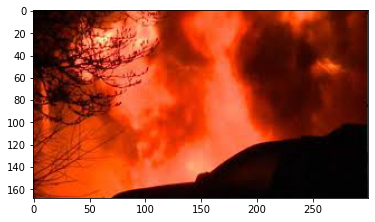

In [426]:
# see the first image

fire_jpg = os.listdir(os.path.join(root_dir, 'Train', 'Fire'))[300]
fire_loc = os.path.join(root_dir, 'Train', 'Fire') +'/' + fire_jpg
fire_img = imread(fire_loc)
plt.imshow(fire_img)
print(f'The shape of the image is {fire_img.shape}')

In [427]:
# transform the pict from train and test

img_size = 224
batch_size = 16 #32


# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22

train_transform = transforms.Compose([
                            # transforms.RandomRotation(10), # rotate + / - 10 degree
                            # transforms.RandomHorizontalFlip(), # reverse 50% of images
                            transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                        mean = [0.485, 0.456, 0.406],
                                        std = [0.229, 0.224, 0.225])  
                                      ])

test_transform = transforms.Compose([
                            # transforms.RandomRotation(10), # rotate + / - 10 degree
                            # transforms.RandomHorizontalFlip(), # reverse 50% of images
                            transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                        mean = [0.485, 0.456, 0.406],
                                        std = [0.229, 0.224, 0.225])  
                                      ])



In [428]:
# DataLoader using transforms

#https://stackoverflow.com/questions/49073799/pytorch-testing-with-torchvision-datasets-imagefolder-and-dataloader


train_data = datasets.ImageFolder(os.path.join(root_dir, 'Train'), transform= train_transform)
test_data  = datasets.ImageFolder(os.path.join(root_dir, 'Test'), transform= test_transform)

train_loader = DataLoader(train_data, batch_size= batch_size, shuffle= True)
test_loader  = DataLoader(test_data, batch_size= batch_size, shuffle= True)

class_names = train_data.classes
class_names

['Fire', 'No_Fire']

In [429]:
# check number of images

print(f"No. of images in train {len(train_data)}")
print(f"No. of images in test {len(test_data)}")


No. of images in train 1786
No. of images in test 199


In [430]:
# check the size of batch size and format

for images, labels in train_loader:
    break

images.shape


torch.Size([16, 3, 224, 224])

In [431]:
x = torch.randn(3, 2,2,2)
print(x.shape,x)
y = torch.transpose(x, 1, 0)
print('\n',y.shape, y)


torch.Size([3, 2, 2, 2]) tensor([[[[ 0.3850,  0.8768],
          [-0.2116,  0.0595]],

         [[ 1.7286,  0.2921],
          [-0.6926, -0.8443]]],


        [[[ 0.1840, -0.8426],
          [-1.6972,  0.2067]],

         [[-0.4891,  0.2444],
          [ 1.9228, -0.2224]]],


        [[[-2.3571, -0.8351],
          [-2.2620, -1.0103]],

         [[ 0.5262, -0.6243],
          [ 1.4275,  0.4428]]]])

 torch.Size([2, 3, 2, 2]) tensor([[[[ 0.3850,  0.8768],
          [-0.2116,  0.0595]],

         [[ 0.1840, -0.8426],
          [-1.6972,  0.2067]],

         [[-2.3571, -0.8351],
          [-2.2620, -1.0103]]],


        [[[ 1.7286,  0.2921],
          [-0.6926, -0.8443]],

         [[-0.4891,  0.2444],
          [ 1.9228, -0.2224]],

         [[ 0.5262, -0.6243],
          [ 1.4275,  0.4428]]]])


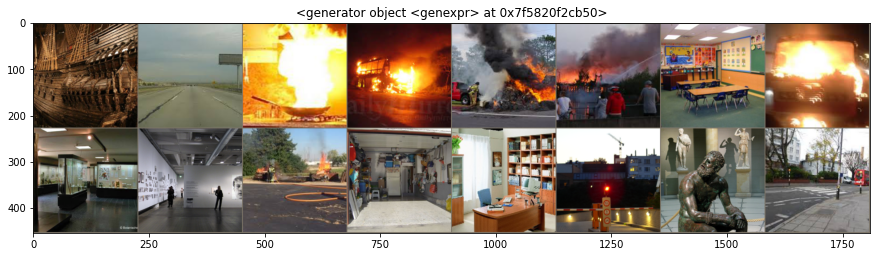

No_Fire No_Fire Fire Fire Fire Fire No_Fire Fire No_Fire No_Fire Fire No_Fire No_Fire No_Fire No_Fire No_Fire 

In [432]:
# visulaize some of the Fire / No_Fire from train picture using reverse normalization


#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

im = make_grid(images, row=2)

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821

inv_normalize = transforms.Normalize(
                    mean = [ -0.485/0.229, -0.456/0.224, -0.406/0.225], # -[0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]
                    std  = [ 1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
plt.figure(figsize = (15, 10))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0))) # to be transposed 1, 2, 0
plt.title( class_names[x] for x in labels)
plt.show()
for lbl in labels:
    print(class_names[lbl], end= ' ') # 0 = Fire, 1= No_Fire
 

### Pre-trained Model

In [433]:
# calling the pre-trained model

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

resnet50_model = models.resnet50(pretrained= True).to(device)

resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [434]:
# Freeze feature parameters

for param in resnet50_model.parameters():
    param.requires_grad = False


In [435]:
# add a new fc of binary class instead of 1000 classes

resnet50_model.fc = nn.Sequential(
                            nn.Linear(2048, 128),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(128, 2),
                            nn.LogSoftmax(dim=1)).to(device)

resnet50_model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [436]:
# check parameters

def check_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(item)
    print('-' *30)
    print(sum(params))

check_parameters(resnet50_model)

262144
128
256
2
------------------------------
262530


In [437]:
#loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.fc.parameters(), lr= 3e-4) # optimizing only the last layers

# resnet50_model.to(device)


In [438]:
# Train the model

num_epochs = 50 #50

start_time = time.time()

train_loss, test_loss = [], []
train_corr, test_corr = [], []

for i in range(num_epochs):
    trn_corr, tst_corr = 0, 0

    for b, (X_train, y_train) in enumerate(train_loader):

        b +=1 # epoch starts from 1

        #apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = resnet50_model(X_train)
        loss = criterion(y_pred, y_train)

        # Calculate number of correct predictions
        predicted = torch.max(y_pred.data, 1) [1] # consider only second item
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim result
        if b % 50 == 0:
            print(f"epoch:{i:2}, batch:{b:4}, loss:{loss.item():10.8f}, \
            acc:{trn_corr.item()*100 / (batch_size * b):8.3f}%")

    train_loss.append(loss)
    train_corr.append(trn_corr)


    #Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            #apply the model
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = resnet50_model(X_test)

            #check the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
        
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_corr.append(tst_corr)

print(f"Duration: {time.time() - start_time:.0f} seconds") # print elapsed time


epoch: 0, batch:  50, loss:0.17899378,             acc:  82.625%
epoch: 0, batch: 100, loss:1.00101590,             acc:  86.625%
epoch: 1, batch:  50, loss:0.09913106,             acc:  95.875%
epoch: 1, batch: 100, loss:0.02342403,             acc:  96.062%
epoch: 2, batch:  50, loss:0.17413358,             acc:  97.125%
epoch: 2, batch: 100, loss:0.06077573,             acc:  96.875%
epoch: 3, batch:  50, loss:0.02100517,             acc:  97.125%
epoch: 3, batch: 100, loss:0.02943250,             acc:  96.812%
epoch: 4, batch:  50, loss:0.07369197,             acc:  97.625%
epoch: 4, batch: 100, loss:0.51037943,             acc:  96.438%
epoch: 5, batch:  50, loss:0.05858616,             acc:  97.375%
epoch: 5, batch: 100, loss:0.28521702,             acc:  96.875%
epoch: 6, batch:  50, loss:0.03465296,             acc:  97.625%
epoch: 6, batch: 100, loss:0.02993784,             acc:  97.438%
epoch: 7, batch:  50, loss:0.01272003,             acc:  98.375%
epoch: 7, batch: 100, los

In [439]:
# check the test accuracy

print('Test Accuracy')
print(f"Test Accuracy: {100*test_corr[-1].item() / ( len(test_data)):.3f}% ")

Test Accuracy
Test Accuracy: 95.980% 


In [440]:
len(test_data)

199

In [441]:
test_corr

[tensor(194, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(196, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(186, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(189, device='cuda:0'),
 tensor(190, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(187, device='cuda:0'),
 tensor(185, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(190, device='cuda:0'),
 tensor(193, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(187, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(194, device='cuda:0'),
 tensor(192, device='cuda:0'),
 tensor(186, device='cuda:0'),
 tensor(186, device='cuda:0'),
 tensor(193, device='cuda:0'),
 tensor(

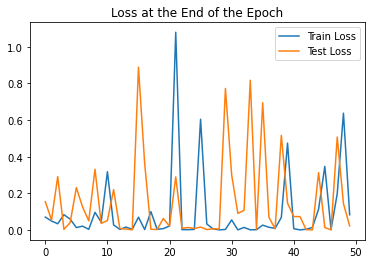

In [442]:
# Plot Model Peformance - Loss

plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss,  label = 'Test Loss')
plt.title ('Loss at the End of the Epoch')
plt.legend()
plt.show()


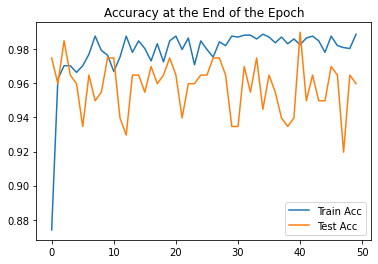

In [443]:
# Plot Model Peformance - Accuracy

plt.plot([t/len(train_data) for t in train_corr], label= 'Train Acc')
plt.plot([t/len(test_data) for t in test_corr], label= 'Test Acc')
plt.title('Accuracy at the End of the Epoch')
plt.legend()
plt.show()

In [444]:
train_corr

[tensor(1561, device='cuda:0'),
 tensor(1719, device='cuda:0'),
 tensor(1733, device='cuda:0'),
 tensor(1733, device='cuda:0'),
 tensor(1726, device='cuda:0'),
 tensor(1733, device='cuda:0'),
 tensor(1745, device='cuda:0'),
 tensor(1764, device='cuda:0'),
 tensor(1749, device='cuda:0'),
 tensor(1744, device='cuda:0'),
 tensor(1727, device='cuda:0'),
 tensor(1742, device='cuda:0'),
 tensor(1764, device='cuda:0'),
 tensor(1747, device='cuda:0'),
 tensor(1759, device='cuda:0'),
 tensor(1751, device='cuda:0'),
 tensor(1738, device='cuda:0'),
 tensor(1756, device='cuda:0'),
 tensor(1737, device='cuda:0'),
 tensor(1759, device='cuda:0'),
 tensor(1764, device='cuda:0'),
 tensor(1750, device='cuda:0'),
 tensor(1762, device='cuda:0'),
 tensor(1734, device='cuda:0'),
 tensor(1759, device='cuda:0'),
 tensor(1750, device='cuda:0'),
 tensor(1742, device='cuda:0'),
 tensor(1758, device='cuda:0'),
 tensor(1754, device='cuda:0'),
 tensor(1764, device='cuda:0'),
 tensor(1763, device='cuda:0'),
 tensor(

Pict is 12 and the size is torch.Size([3, 224, 224])
Predicted Value:0 and class is Fire


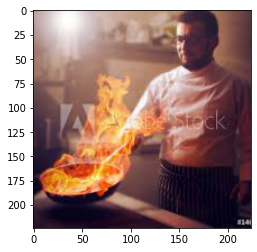

In [478]:
# cheking one of the random picture

x = np.random.randint(len(test_data))
print(f'Pict is {x} and the size is {test_data[x][0].shape}')
im = inv_normalize(test_loc[x][0])
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))


# evaluate with the model

resnet50_model.eval()
im = im.to(device)
with torch.no_grad():
    # new_pred = resnet50_model(test_data[x][0].view(1, 3, 224, 224)).argmax().to(device)
    new_pred = resnet50_model(im.view(1, 3, 224, 224)).argmax().to(device)

print(f'Predicted Value:{new_pred.item()} and class is {class_names[new_pred.item()]}')